# Create all image csv files

In [1]:
import os
import csv

def create_csv(image_folder, csv_file_path):
    # Define the CSV header fields
    fieldnames = ['HospitalID', 'PatientID', 'ImageID', 'ImagePath', 'Label']
    
    # Open the CSV file in write mode
    with open(csv_file_path, 'w', newline='') as csvfile:
        # Create a CSV writer object and write the header
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        # Iterate through files in the folder
        for filename in sorted(os.listdir(image_folder)):
            # Construct the complete image file path
            image_path = os.path.join(image_folder, filename)

            # Parse the filename to extract HospitalID, PatientID, image number, and image label
            parts = filename.split('_')
            hospital_id = parts[3]
            patient_id = parts[1]
            image_number = parts[6]
            image_label = parts[4]

            # Write data into the CSV file
            writer.writerow({
                'HospitalID': hospital_id,
                'PatientID': patient_id,
                'ImageID': image_number,
                'ImagePath': image_path,
                'Label': image_label
            })

    # Print a message indicating that the CSV file has been created and saved
    print("CSV file has been created and saved to:", csv_file_path)


image_folder = "/local/data1/honzh073/data/8bit_down224"
csv_file_path = "/local/data1/honzh073/local_repo/FL/code/5_attention/csv_files/image_data.csv"
create_csv(image_folder, csv_file_path)


FileNotFoundError: [Errno 2] No such file or directory: '/local/data1/honzh073/data/8bit_downsample_256'

# create train, val csv

In [60]:
import csv
from collections import defaultdict
import random

def split_and_save_data(input_csv_path, output_folder, target_hospital_ids, train_ratio, seed):
    patient_data = defaultdict(list)
    
    with open(input_csv_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['HospitalID'] in target_hospital_ids:
                patient_id = row['PatientID']
                patient_data[patient_id].append(row)

    num_patients = len(patient_data)

    num_train = int(num_patients * train_ratio)

    # get random IDs
    all_patient_ids = list(patient_data.keys())

    random.seed(seed)
    random.shuffle(all_patient_ids)

    # split by ID
    train_patients = all_patient_ids[ : num_train]
    test_patients = all_patient_ids[num_train: ]

    # iter by patient IDs
    train_data = []
    test_data = []

    for patient_id, images in patient_data.items():
        if patient_id in train_patients:
            train_data.extend(images)
        elif patient_id in test_patients:
            test_data.extend(images)

    # write to csv
    def write_to_csv(file_path, data):
        with open(file_path, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=data[0].keys())
            writer.writeheader()
            writer.writerows(data)

    # Write to CSV files
    write_to_csv(os.path.join(output_folder, 'cross_train.csv'), train_data)
    write_to_csv(os.path.join(output_folder, 'cross_test.csv'), test_data)
    
    print("Saved train.csv, test.csv.")

# input and output path
input_csv_path = "/local/data1/honzh073/local_repo/FL/code/5_attention/image_data.csv"
output_folder = '/local/data1/honzh073/local_repo/FL/code/5_attention'

# single hospital id
target_hospital_ids = ['43']

# random seed
seed = 1

# train and val dataset ratio
train_ratio = 0.7
# test_ratio = 0.3 # unnecessary

split_and_save_data(input_csv_path, output_folder,
                    train_ratio=train_ratio,
                    target_hospital_ids = target_hospital_ids,
                    seed = seed)


Saved train.csv, test.csv.


In [61]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
   
def plot_roc_curve(all_labels, all_predictions):
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def show_image(dataset, num_images=5):
    # Get random indices
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    # Plot images with truncated names
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Use the dataset directly
        filename = dataset.data[idx][0]  # Get the filename from dataset's internal data attribute
        truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
        
        # Print the original filename
        print(f"Image location: {filename}")

        plt.subplot(1, num_images, i + 1)
        plt.title(f"Label: {label}")
        plt.imshow(image[0])  # Assuming single-channel (grayscale) image
        # plt.imshow(image[0], cmap='gray')  # Assuming single-channel (grayscale) image

        plt.axis('off')
    plt.show()
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_classweight(train_dataset):
    train_nff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
    train_aff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF
    class_weight_nff = 1 / (2 * (train_nff_count / (train_nff_count + train_aff_count)))
    class_weight_aff = 1 / (2 * (train_aff_count / (train_nff_count + train_aff_count)))
    
    return [class_weight_nff, class_weight_aff] # 0 nff , 1 aff


def test_model(model, test_dataset, batch_size):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    model.eval()
    
    correct_test = 0
    total_test = 0
    test_loss = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += loss.item()

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")
     
    auc_score = roc_auc_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    # Precision、Recall、F1 Score
    class_labels = {0: 'NFF', 1: 'AFF'}

    classification_rep = classification_report(all_labels, all_predictions, target_names=[class_labels[i] for i in range(len(class_labels))])
    print("AUC:", auc_score)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_rep)

    plot_roc_curve(all_labels, all_predictions)

training class weight [0.7363636363636363, 1.5576923076923077]
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_NGLGWBFXUD_hospital_43_AFF_image_3.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_JTCVKHWOJN_hospital_43_AFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_DSMCSEUNOF_hospital_43_NFF_image_4.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_GHXSWJQAXM_hospital_43_NFF_image_3.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_NGLGWBFXUD_hospital_43_AFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_TADAVBRLUJ_hospital_43_NFF_image_3.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_GXVLZPGVLG_hospital_43_NFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_EYRSUJGIZG_hospital_43_AFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_downsampl

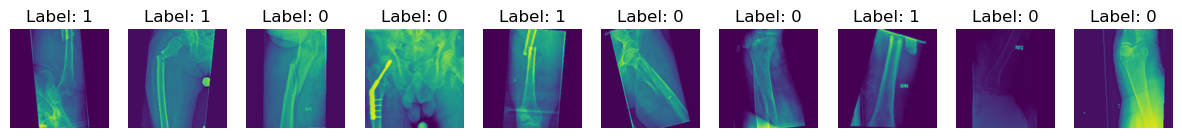

Saved train.csv, val.csv, test.csv.
-----------------------------------
train AFF: 52, ratio: 0.32
----- NFF: 110, ratio: 0.68
-----------------------------------
test AFF: 23, ratio: 0.28
---- NFF: 60, ratio: 0.72


In [62]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import csv
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from sklearn.model_selection import KFold

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.labels = []  # Store labels separately
        self.patient_ids = []  # Store patient IDs separately
        self.transform = transform
        
        # read csv
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']
                patient_id = row['PatientID']  # Assuming 'PatientID' is the column name in your CSV file

                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")
                self.data.append((image_path, label))
                self.labels.append(label)
                self.patient_ids.append(patient_id)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define your image transformations for training and testing
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAdjustSharpness(sharpness_factor=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets using CustomDataset class
train_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/cross_train.csv', transform=train_transform)
test_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/cross_test.csv', transform=test_transform)

# classweight
classweight = get_classweight(train_dataset)
print('training class weight', classweight)

# device
# device = torch.device("cuda:0" if  torch.cuda.is_available() else "cpu")

# print images
show_image(train_dataset, 10)

# calculate numbers
print("Saved train.csv, val.csv, test.csv.")
print('-----------------------------------')
train_NFF_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
train_AFF_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF
test_NFF_count = sum(1 for _, label in test_dataset if label == 0)  # 0 NFF
test_AFF_count = sum(1 for _, label in test_dataset if label == 1)  # 1 AFF

print(f"train AFF: {train_AFF_count}, ratio: {train_AFF_count / (train_AFF_count + train_NFF_count):.2f}")
print(f"----- NFF: {train_NFF_count}, ratio: {train_NFF_count / (train_AFF_count + train_NFF_count):.2f}")
print('-----------------------------------')
print(f"test AFF: {test_AFF_count}, ratio: {test_AFF_count / (test_AFF_count + test_NFF_count):.2f}")
print(f"---- NFF: {test_NFF_count}, ratio: {test_NFF_count / (test_AFF_count + test_NFF_count):.2f}")



# Attention

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.hub import load_state_dict_from_url
from torchvision.models import resnet101, ResNet101_Weights

# 定义SE模块
class SEModule(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# 定义带有SE模块的ResNet-101基本块
class SEResNetBottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, reduction=16):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * self.expansion, reduction=reduction)  # 添加SE模块
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out = self.se_module(out)  # 使用SE模块

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# 自定义ResNet-101模型，使用带有SE模块的基本块
class CustomResNet101(nn.Module):
    def __init__(self, num_classes=1000):
        super(CustomResNet101, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(SEResNetBottleneck, 64, 3, stride=1)
        self.layer2 = self._make_layer(SEResNetBottleneck, 128, 4, stride=2)
        self.layer3 = self._make_layer(SEResNetBottleneck, 256, 23, stride=2)
        self.layer4 = self._make_layer(SEResNetBottleneck, 512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * SEResNetBottleneck.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
    
torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# 使用自定义的ResNet-101模型进行训练
model = CustomResNet101(num_classes=2)
# 获取预训练的ResNet-101模型
pretrained_resnet101 = models.resnet101(weights=ResNet101_Weights.DEFAULT)

# 创建自定义ResNet-101模型实例
custom_resnet101 = CustomResNet101(num_classes=2)

# 将预训练模型的权重复制到自定义模型中
# 去掉最后一层，因为预训练模型是用于1000类别的 ImageNet 数据集，而你的任务是2类别的分类
custom_resnet101.load_state_dict(pretrained_resnet101.state_dict(), strict=False)

# # 如果需要，将模型移至GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# custom_resnet101.to(device)

/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1/5
Epoch 1/20, train Loss: 0.0044, val Loss: 1.8041, train ACC: 41.86%, Val ACC: 60.61%
Epoch 2/20, train Loss: 0.4739, val Loss: 0.5796, train ACC: 66.67%, Val ACC: 60.61%
Epoch 3/20, train Loss: 0.5544, val Loss: 0.5745, train ACC: 69.77%, Val ACC: 75.76%
Epoch 4/20, train Loss: 0.5718, val Loss: 0.5794, train ACC: 71.32%, Val ACC: 78.79%
Epoch 5/20, train Loss: 0.4017, val Loss: 0.4202, train ACC: 79.84%, Val ACC: 78.79%
Epoch 6/20, train Loss: 1.0143, val Loss: 0.8260, train ACC: 84.50%, Val ACC: 69.70%
Epoch 7/20, train Loss: 0.0448, val Loss: 0.2923, train ACC: 83.72%, Val ACC: 84.85%
Epoch 8/20, train Loss: 0.0039, val Loss: 0.3332, train ACC: 87.60%, Val ACC: 78.79%
Epoch 9/20, train Loss: 0.0309, val Loss: 0.3504, train ACC: 89.92%, Val ACC: 78.79%
Epoch 10/20, train Loss: 0.2186, val Loss: 0.5885, train ACC: 94.57%, Val ACC: 66.67%
Epoch 11/20, train Loss: 0.9085, val Loss: 0.8088, train ACC: 90.70%, Val ACC: 81.82%
Epoch 12/20, train Loss: 7.7747, val Loss: 2.9329, tra

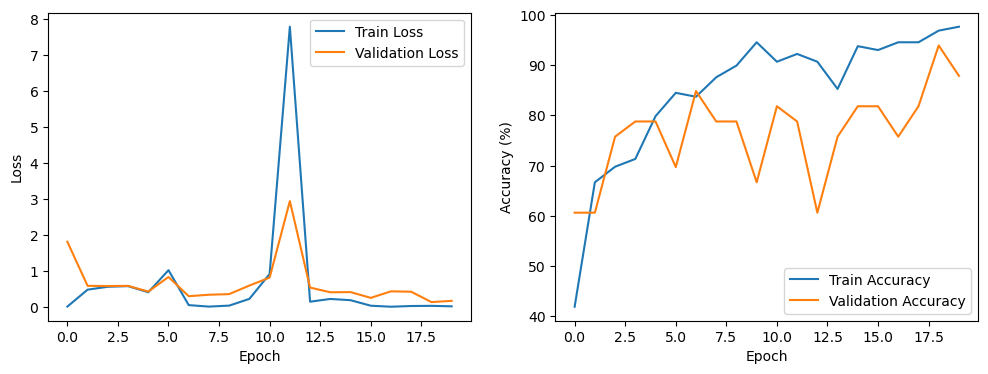

Fold 2/5
Epoch 1/20, train Loss: 0.0000, val Loss: 0.5479, train ACC: 93.02%, Val ACC: 75.76%
Epoch 2/20, train Loss: 0.0000, val Loss: 0.1561, train ACC: 93.80%, Val ACC: 90.91%
Epoch 3/20, train Loss: 0.1088, val Loss: 0.2351, train ACC: 95.35%, Val ACC: 84.85%
Epoch 4/20, train Loss: 0.4359, val Loss: 0.2388, train ACC: 91.47%, Val ACC: 96.97%
Epoch 5/20, train Loss: 1.6452, val Loss: 0.7183, train ACC: 96.90%, Val ACC: 87.88%
Epoch 6/20, train Loss: 0.1193, val Loss: 0.2252, train ACC: 94.57%, Val ACC: 90.91%
Epoch 7/20, train Loss: 0.1354, val Loss: 0.1177, train ACC: 95.35%, Val ACC: 93.94%
Epoch 8/20, train Loss: 0.8120, val Loss: 0.8270, train ACC: 89.15%, Val ACC: 78.79%
Epoch 9/20, train Loss: 0.0929, val Loss: 0.1003, train ACC: 95.35%, Val ACC: 96.97%
Epoch 10/20, train Loss: 0.0150, val Loss: 0.1234, train ACC: 96.90%, Val ACC: 93.94%
Epoch 11/20, train Loss: 0.0314, val Loss: 0.1960, train ACC: 96.12%, Val ACC: 93.94%
Epoch 12/20, train Loss: 3.2826, val Loss: 1.6238, tra

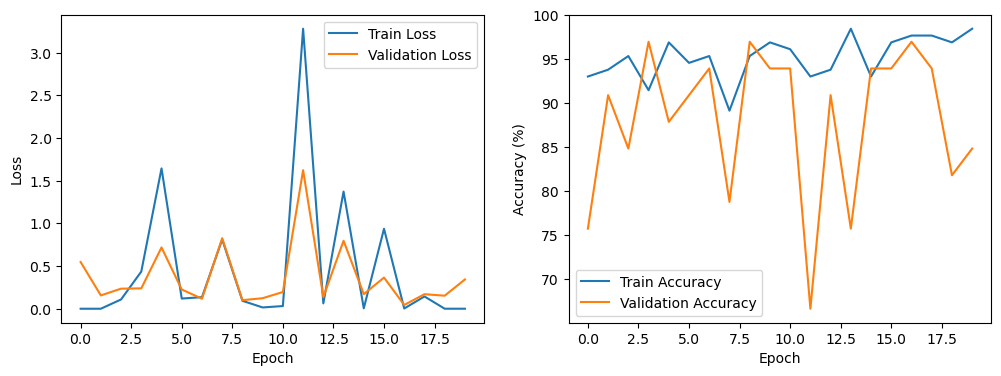

Fold 3/5
Epoch 1/20, train Loss: 0.7814, val Loss: 0.4032, train ACC: 96.15%, Val ACC: 90.62%
Epoch 2/20, train Loss: 0.1416, val Loss: 0.0955, train ACC: 96.15%, Val ACC: 100.00%
Epoch 3/20, train Loss: 0.2639, val Loss: 0.3131, train ACC: 93.85%, Val ACC: 90.62%
Epoch 4/20, train Loss: 0.0115, val Loss: 0.0500, train ACC: 95.38%, Val ACC: 100.00%
Epoch 5/20, train Loss: 0.0091, val Loss: 0.0325, train ACC: 99.23%, Val ACC: 96.88%
Epoch 6/20, train Loss: 0.0512, val Loss: 0.0341, train ACC: 97.69%, Val ACC: 100.00%
Epoch 7/20, train Loss: 0.0221, val Loss: 0.0245, train ACC: 99.23%, Val ACC: 100.00%
Epoch 8/20, train Loss: 0.0212, val Loss: 0.0214, train ACC: 97.69%, Val ACC: 100.00%
Epoch 9/20, train Loss: 0.0197, val Loss: 0.0240, train ACC: 96.92%, Val ACC: 100.00%
Epoch 10/20, train Loss: 0.0373, val Loss: 0.0341, train ACC: 99.23%, Val ACC: 100.00%
Epoch 11/20, train Loss: 0.0223, val Loss: 0.0284, train ACC: 99.23%, Val ACC: 100.00%
Epoch 12/20, train Loss: 0.1335, val Loss: 0.1

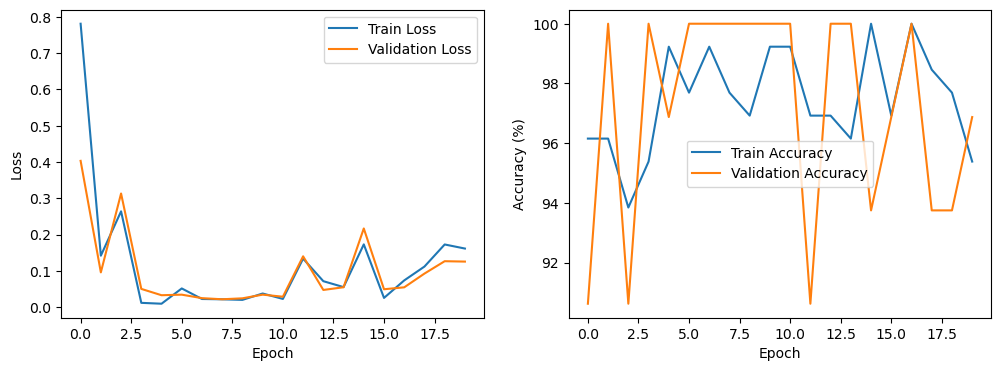

Fold 4/5
Epoch 1/20, train Loss: 0.3292, val Loss: 0.2984, train ACC: 96.15%, Val ACC: 78.12%
Epoch 2/20, train Loss: 0.0475, val Loss: 0.0492, train ACC: 93.85%, Val ACC: 100.00%
Epoch 3/20, train Loss: 0.0787, val Loss: 0.0447, train ACC: 98.46%, Val ACC: 96.88%
Epoch 4/20, train Loss: 0.0176, val Loss: 0.0574, train ACC: 100.00%, Val ACC: 96.88%
Epoch 5/20, train Loss: 0.0398, val Loss: 0.0323, train ACC: 100.00%, Val ACC: 100.00%
Epoch 6/20, train Loss: 0.0073, val Loss: 0.0221, train ACC: 99.23%, Val ACC: 100.00%
Epoch 7/20, train Loss: 0.1012, val Loss: 0.0563, train ACC: 99.23%, Val ACC: 96.88%
Epoch 8/20, train Loss: 0.0459, val Loss: 0.0505, train ACC: 99.23%, Val ACC: 96.88%
Epoch 9/20, train Loss: 0.0441, val Loss: 0.0251, train ACC: 99.23%, Val ACC: 96.88%
Epoch 10/20, train Loss: 0.0014, val Loss: 0.0065, train ACC: 99.23%, Val ACC: 100.00%
Epoch 11/20, train Loss: 0.0419, val Loss: 0.0322, train ACC: 97.69%, Val ACC: 100.00%
Epoch 12/20, train Loss: 0.0328, val Loss: 0.02

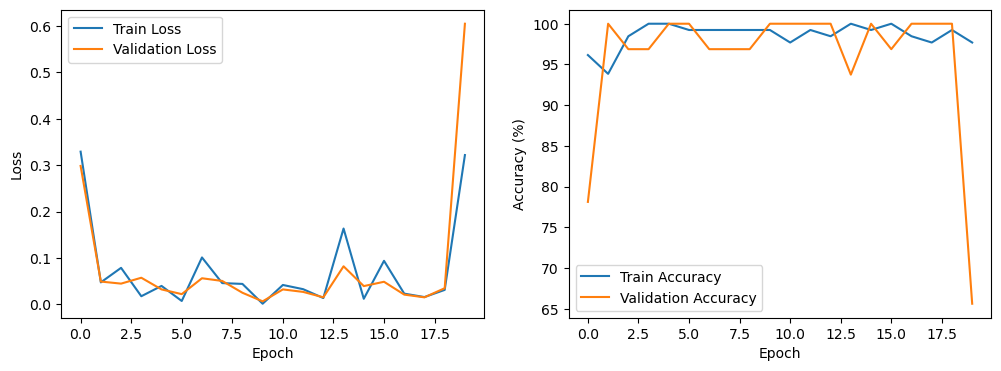

Fold 5/5
Epoch 1/20, train Loss: 0.0425, val Loss: 0.0717, train ACC: 98.46%, Val ACC: 96.88%
Epoch 2/20, train Loss: 0.1500, val Loss: 0.1759, train ACC: 96.92%, Val ACC: 90.62%
Epoch 3/20, train Loss: 0.0206, val Loss: 0.0354, train ACC: 99.23%, Val ACC: 100.00%
Epoch 4/20, train Loss: 0.0649, val Loss: 0.0491, train ACC: 98.46%, Val ACC: 96.88%
Epoch 5/20, train Loss: 0.0182, val Loss: 0.0276, train ACC: 98.46%, Val ACC: 96.88%
Epoch 6/20, train Loss: 0.0219, val Loss: 0.0405, train ACC: 97.69%, Val ACC: 100.00%
Epoch 7/20, train Loss: 0.0045, val Loss: 0.0070, train ACC: 100.00%, Val ACC: 100.00%
Epoch 8/20, train Loss: 0.0077, val Loss: 0.0115, train ACC: 99.23%, Val ACC: 100.00%
Epoch 9/20, train Loss: 0.1138, val Loss: 0.1240, train ACC: 99.23%, Val ACC: 90.62%
Epoch 10/20, train Loss: 0.0125, val Loss: 0.0172, train ACC: 100.00%, Val ACC: 100.00%
Epoch 11/20, train Loss: 0.0279, val Loss: 0.0167, train ACC: 96.92%, Val ACC: 100.00%
Epoch 12/20, train Loss: 0.0018, val Loss: 0.0

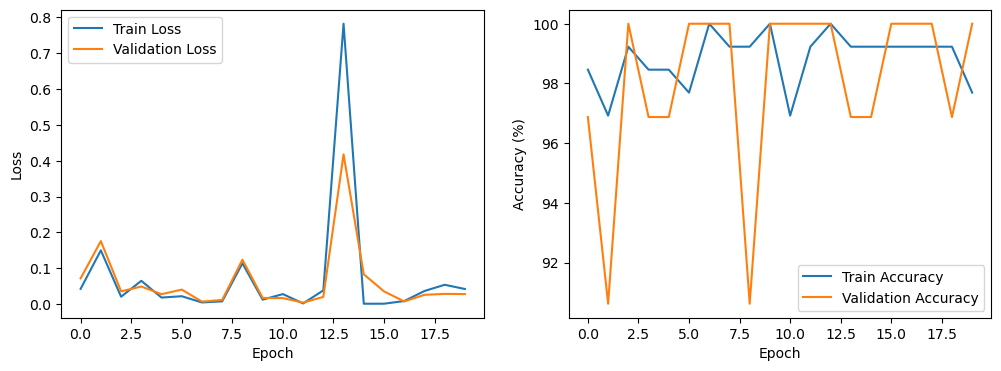

In [63]:
from sklearn.model_selection import StratifiedKFold

model = custom_resnet101

classweight = get_classweight(train_dataset)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the ResNet-101 model
model = models.resnet101(weights=ResNet101_Weights.DEFAULT)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Assuming 2 classes, change it according to your problem
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=torch.Tensor(classweight).to(device))

optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# ------------------------------------------------------------------------------------------

# Define the number of splits for cross-validation
n_splits = 5

# kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

# k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)), train_dataset.patient_ids)):

# for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)))):
    print(f'Fold {fold + 1}/{n_splits}')

    # Create data loaders for training and validation subsets
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler)
    val_loader = DataLoader(train_dataset, batch_size=16, sampler=val_sampler)

    # Training loop
    num_epochs = 20  # number of epochs
    
    # Loss, ACC
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        
        model.eval()
        correct_validation_aff = 0
        total_validation_aff = 0
        correct_validation = 0
        total_validation = 0
        validation_loss = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()
                validation_loss += loss.item()
                # Calculate accuracy for AFF class
                total_validation_aff += torch.sum(labels == 1).item()
                correct_validation_aff += torch.sum((predicted == 1) & (labels == 1)).item()

        # validation accuracy and loss
        validation_accuracy = 100 * correct_validation / total_validation
        validation_loss /= len(val_loader)
        
        train_losses.append(loss.item())
        validation_losses.append(validation_loss)
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
            f"train Loss: {loss.item():.4f}, "
            f"val Loss: {validation_loss:.4f}, "
            f"train ACC: {train_accuracy:.2f}%, "
            f"Val ACC: {validation_accuracy:.2f}%")
    scheduler.step()
        
    # Plot train/val loss,  accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(validation_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend() 

    plt.show()



Test Loss: 0.4645, Test Acc: 81.93%
AUC: 0.8481884057971015
Confusion Matrix:
[[47 13]
 [ 2 21]]
Classification Report:
              precision    recall  f1-score   support

         NFF       0.96      0.78      0.86        60
         AFF       0.62      0.91      0.74        23

    accuracy                           0.82        83
   macro avg       0.79      0.85      0.80        83
weighted avg       0.86      0.82      0.83        83



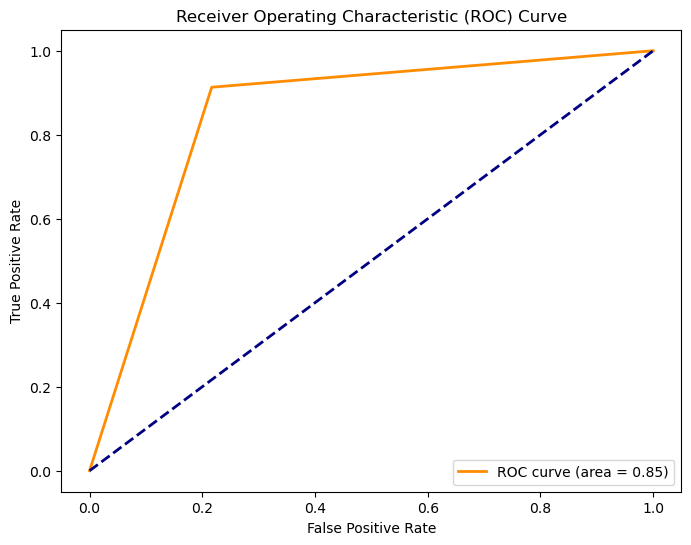

In [64]:
# Resnet 101
test_model(model=model, test_dataset=test_dataset, batch_size=16)


In [65]:
# import torch
# from torchvision import models
# from torchviz import make_dot

# # 定义ResNet-101模型
# model = models.resnet101(pretrained=True)

# # 创建一个虚拟输入张量（batch size为1，通道数为3，图像尺寸为224x224）
# dummy_input = torch.randn(1, 3, 224, 224)

# # 将模型和输入张量传递给make_dot函数，生成图形
# dot = make_dot(model(dummy_input), params=dict(model.named_parameters()))

# # 保存图形为PDF文件
# dot.format = 'pdf'
# dot.render(filename='/local/data1/honzh073/local_repo/FL/code/3_single_hospital')


# ResNet 152

In [66]:
# from sklearn.model_selection import StratifiedKFold
# from torchvision.models import resnet152, ResNet152_Weights

# classweight = get_classweight(train_dataset)

# torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Define the ResNet-101 model
# model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 2)  # Assuming 2 classes, change it according to your problem
# model = model.to(device)

# # Define your loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=torch.Tensor(classweight).to(device))

# optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
# # scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# # Define the number of splits for cross-validation
# n_splits = 5
# # kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
# kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
# # Perform k-fold cross-validation
# for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)), train_dataset.patient_ids)):

# # for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)))):
#     print(f'Fold {fold + 1}/{n_splits}')

#     # Create data loaders for training and validation subsets
#     train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
#     val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

#     train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler)
#     val_loader = DataLoader(train_dataset, batch_size=16, sampler=val_sampler)

#     # Training loop
#     num_epochs = 20  # Choose the number of epochs
#         # Loss, ACC
#     train_losses = []
#     validation_losses = []
#     train_accuracies = []
#     validation_accuracies = []
    
#     for epoch in range(num_epochs):
#         model.train()
#         correct_train = 0
#         total_train = 0
        
#         for images, labels in train_loader:
#             images = images.to(device)
#             labels = labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             _, predicted = torch.max(outputs.data, 1)
#             total_train += labels.size(0)
#             correct_train += (predicted == labels).sum().item()
        
#         train_accuracy = 100 * correct_train / total_train
        
#         model.eval()
#         correct_validation_aff = 0
#         total_validation_aff = 0
#         correct_validation = 0
#         total_validation = 0
#         validation_loss = 0
        
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 images = images.to(device)
#                 labels = labels.to(device)
                
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
                
#                 _, predicted = torch.max(outputs.data, 1)
#                 total_validation += labels.size(0)
#                 correct_validation += (predicted == labels).sum().item()
#                 validation_loss += loss.item()
#                 # Calculate accuracy for AFF class
#                 total_validation_aff += torch.sum(labels == 1).item()
#                 correct_validation_aff += torch.sum((predicted == 1) & (labels == 1)).item()

#         validation_accuracy_aff = 100 * correct_validation_aff / total_validation_aff

#         # validation accuracy and loss
#         validation_accuracy = 100 * correct_validation / total_validation
#         validation_loss /= len(val_loader)
        
#         train_losses.append(loss.item())
#         validation_losses.append(validation_loss)
#         train_accuracies.append(train_accuracy)
#         validation_accuracies.append(validation_accuracy)
        
#         print(f"Epoch {epoch+1}/{num_epochs}, "
#             f"train Loss: {loss.item():.4f}, "
#             f"val Loss: {validation_loss:.4f}, "
#             f"train ACC: {train_accuracy:.2f}%, "
#             f"Val ACC: {validation_accuracy:.2f}%")
#         # scheduler.step()




In [67]:
# # resnet 152
# test_model(model=model, test_dataset=test_dataset, batch_size=66)
